## FashionMNIST CNN Analysis 

# 1. Libraries and Device Setup


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


# 2. Load FashionMNIST Dataset

In [30]:
# Hyperparameters
num_classes = 10 
num_epochs = 20
batch_size = 128
lr = 0.001

In [31]:
# Load train and test datasets
train_data = dsets.FashionMNIST(root = './data',train = True,download = True,transform=transforms.ToTensor())
test_data = dsets.FashionMNIST(root = './data',train= False,transform = transforms.ToTensor()) 

In [32]:
# Data loaders
train_gen = torch.utils.data.DataLoader(dataset = train_data,batch_size = batch_size,shuffle = True)
test_gen = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size,shuffle = False)

# 3. Define the CNN Model

In [26]:
class Net(nn.Module):
    def __init__(self,num_classes):
        super(Net,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.classifier = nn.Sequential(nn.Dropout(0.5),
                                       nn.Linear(64*3*3,128),
                                       nn.ReLU(),
                                       nn.Linear(128,num_classes))
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x
        

In [33]:
# Initialize the model
net = Net(num_classes)
net.to(device)
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=576, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


# 4. Define Loss and Optimizer

In [34]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=lr)


# 5. Training Loop with Evaluation

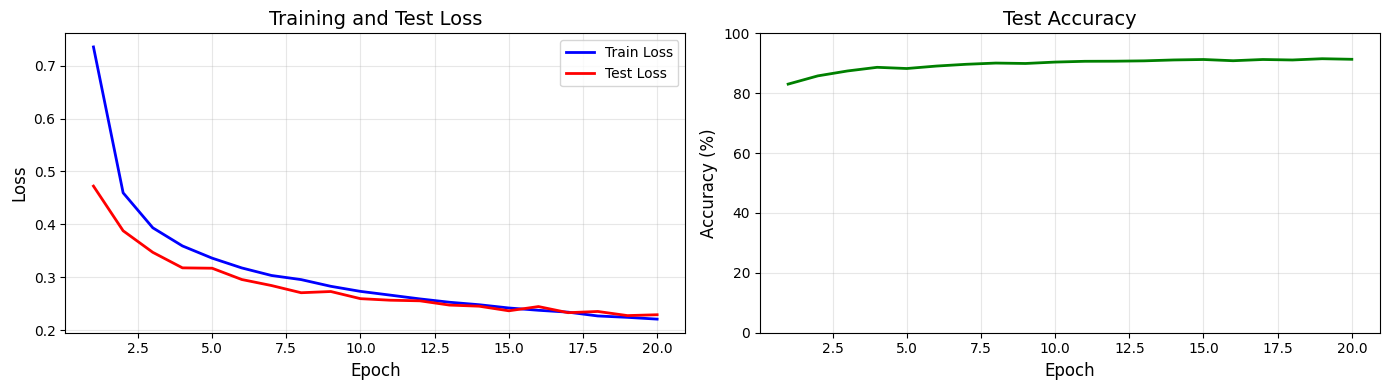


Epoch [20/20] Summary:
  Train Loss: 0.2206
  Test Loss: 0.2289
  Test Accuracy: 91.33%



In [35]:
train_losses = []
test_losses = []
test_accuracies = []
epochs_list = []


def evaluate_model():
    net.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in test_gen:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = total_loss / len(test_gen)
    accuracy = 100 * correct / total
    net.train()
    return avg_loss, accuracy


def plot_metrics():
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    # Loss
    ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs_list, test_losses, 'r-', label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Test Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy
    ax2.plot(epochs_list, test_accuracies, 'g-', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Test Accuracy', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 100])
    
    plt.tight_layout()
    plt.show()


for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    num_batches = 0
    
    for i, (images, labels) in enumerate(train_gen):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                  %(epoch+1, num_epochs, i+1, len(train_gen), loss.item()))
    
    avg_train_loss = epoch_loss / num_batches
    test_loss, test_accuracy = evaluate_model()
    
    
    epochs_list.append(epoch + 1)
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    plot_metrics()
    print(f'\nEpoch [{epoch+1}/{num_epochs}] Summary:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Test Loss: {test_loss:.4f}')
    print(f'  Test Accuracy: {test_accuracy:.2f}%\n')

# 6. Final Model Evaluation

FINAL MODEL PERFORMANCE
Best Test Accuracy: 91.72%
Final Test Accuracy: 91.67%
Final Train Loss: 0.2065
Final Test Loss: 0.2240


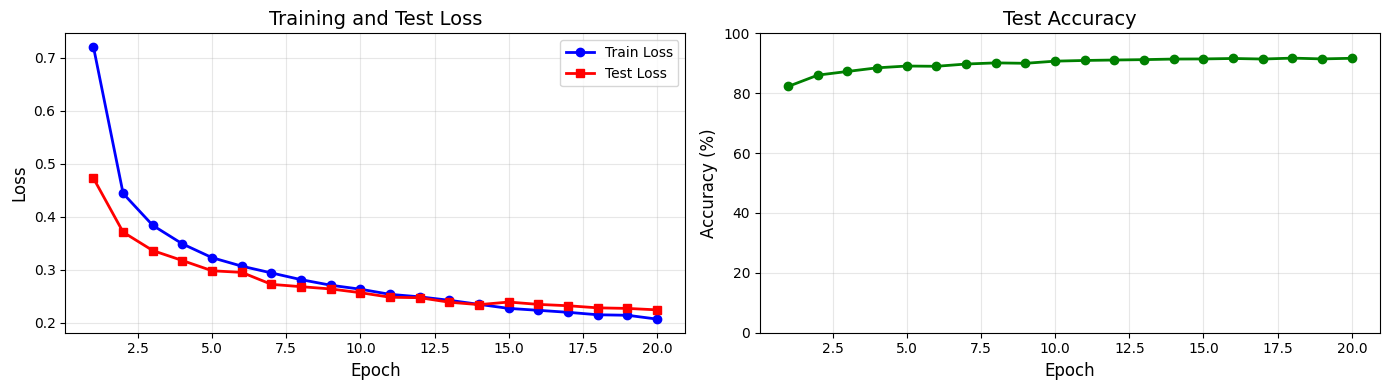

In [ ]:

print('='*60)
print('FINAL MODEL PERFORMANCE')
print('='*60)
print(f'Best Test Accuracy: {max(test_accuracies):.2f}%')
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')
print(f'Final Train Loss: {train_losses[-1]:.4f}')
print(f'Final Test Loss: {test_losses[-1]:.4f}')
print('='*60)

# Re-plot final metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Plot losses
ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o')
ax1.plot(epochs_list, test_losses, 'r-', label='Test Loss', linewidth=2, marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs_list, test_accuracies, 'g-', linewidth=2, marker='o')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Test Accuracy', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

# 7. Visualize Learned Convolutional Filters

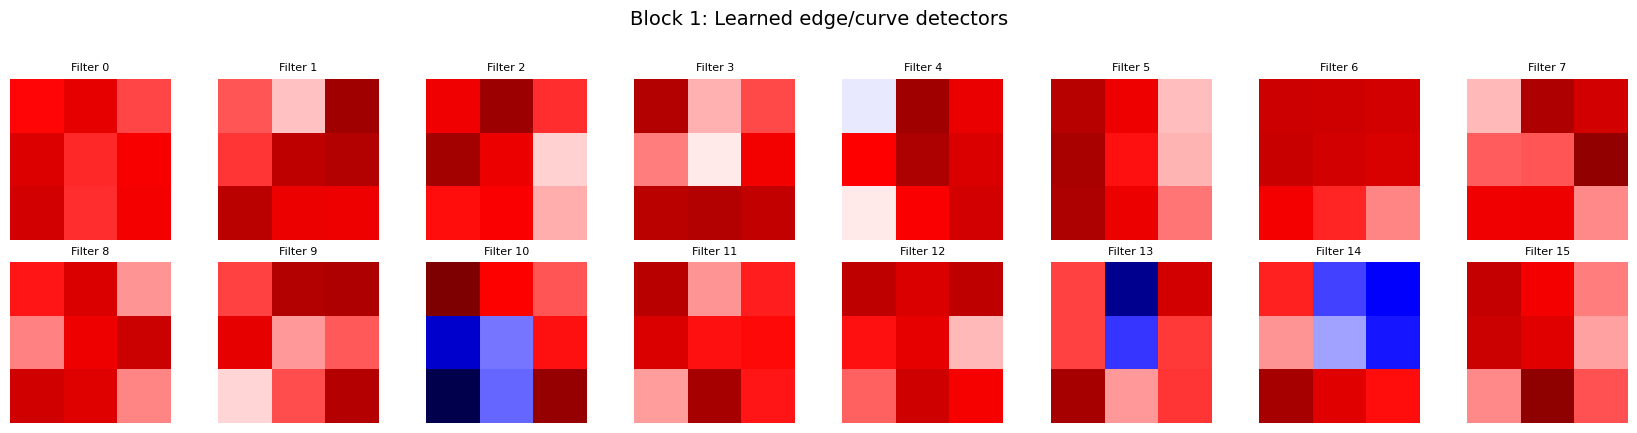

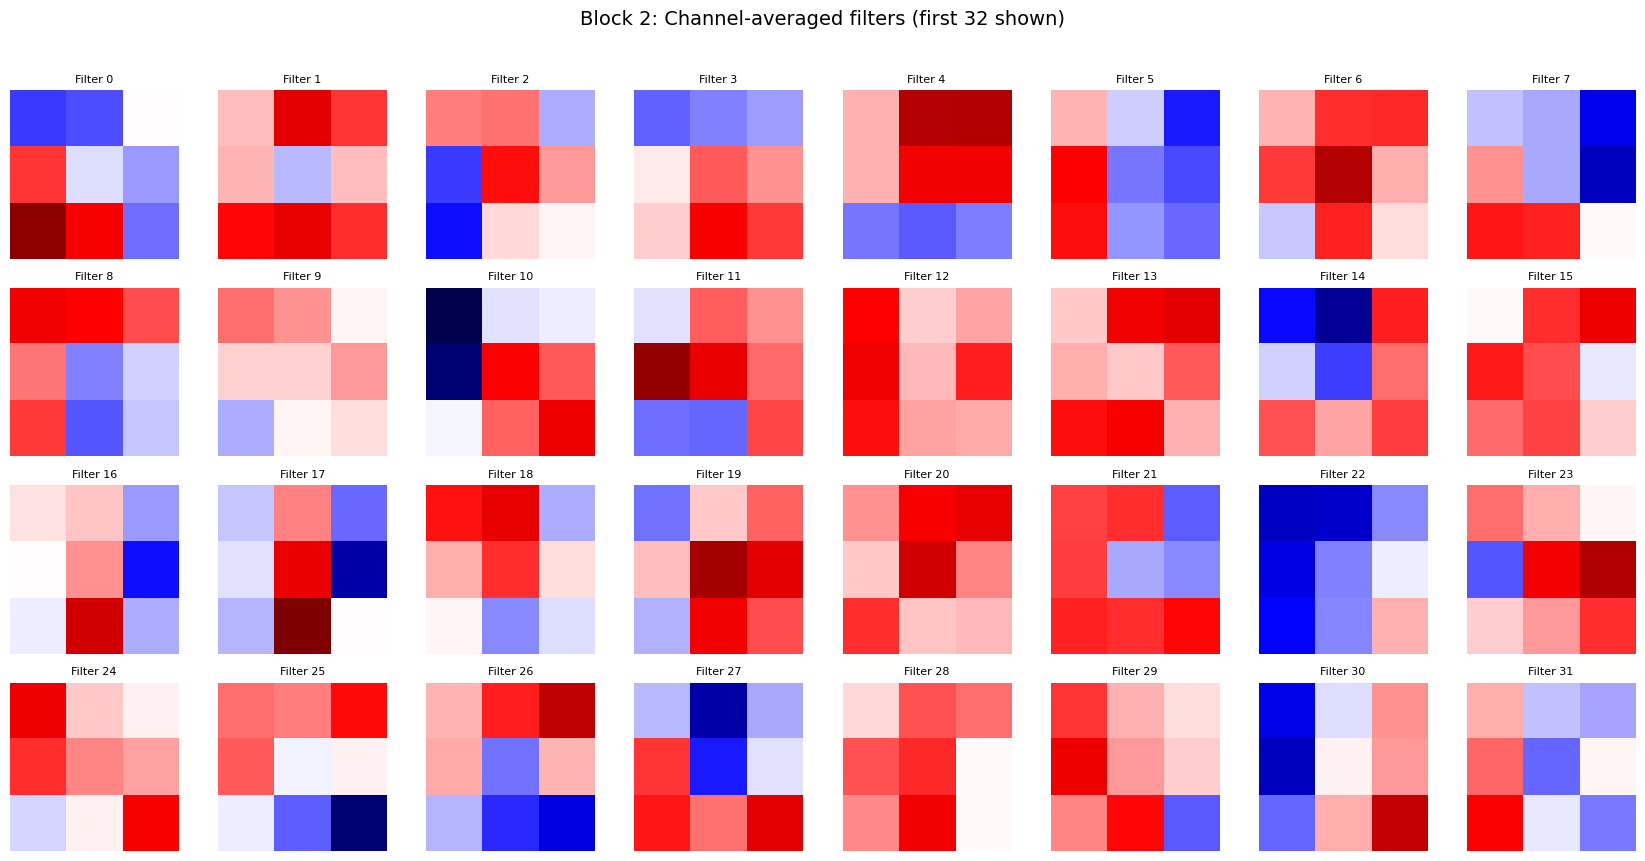

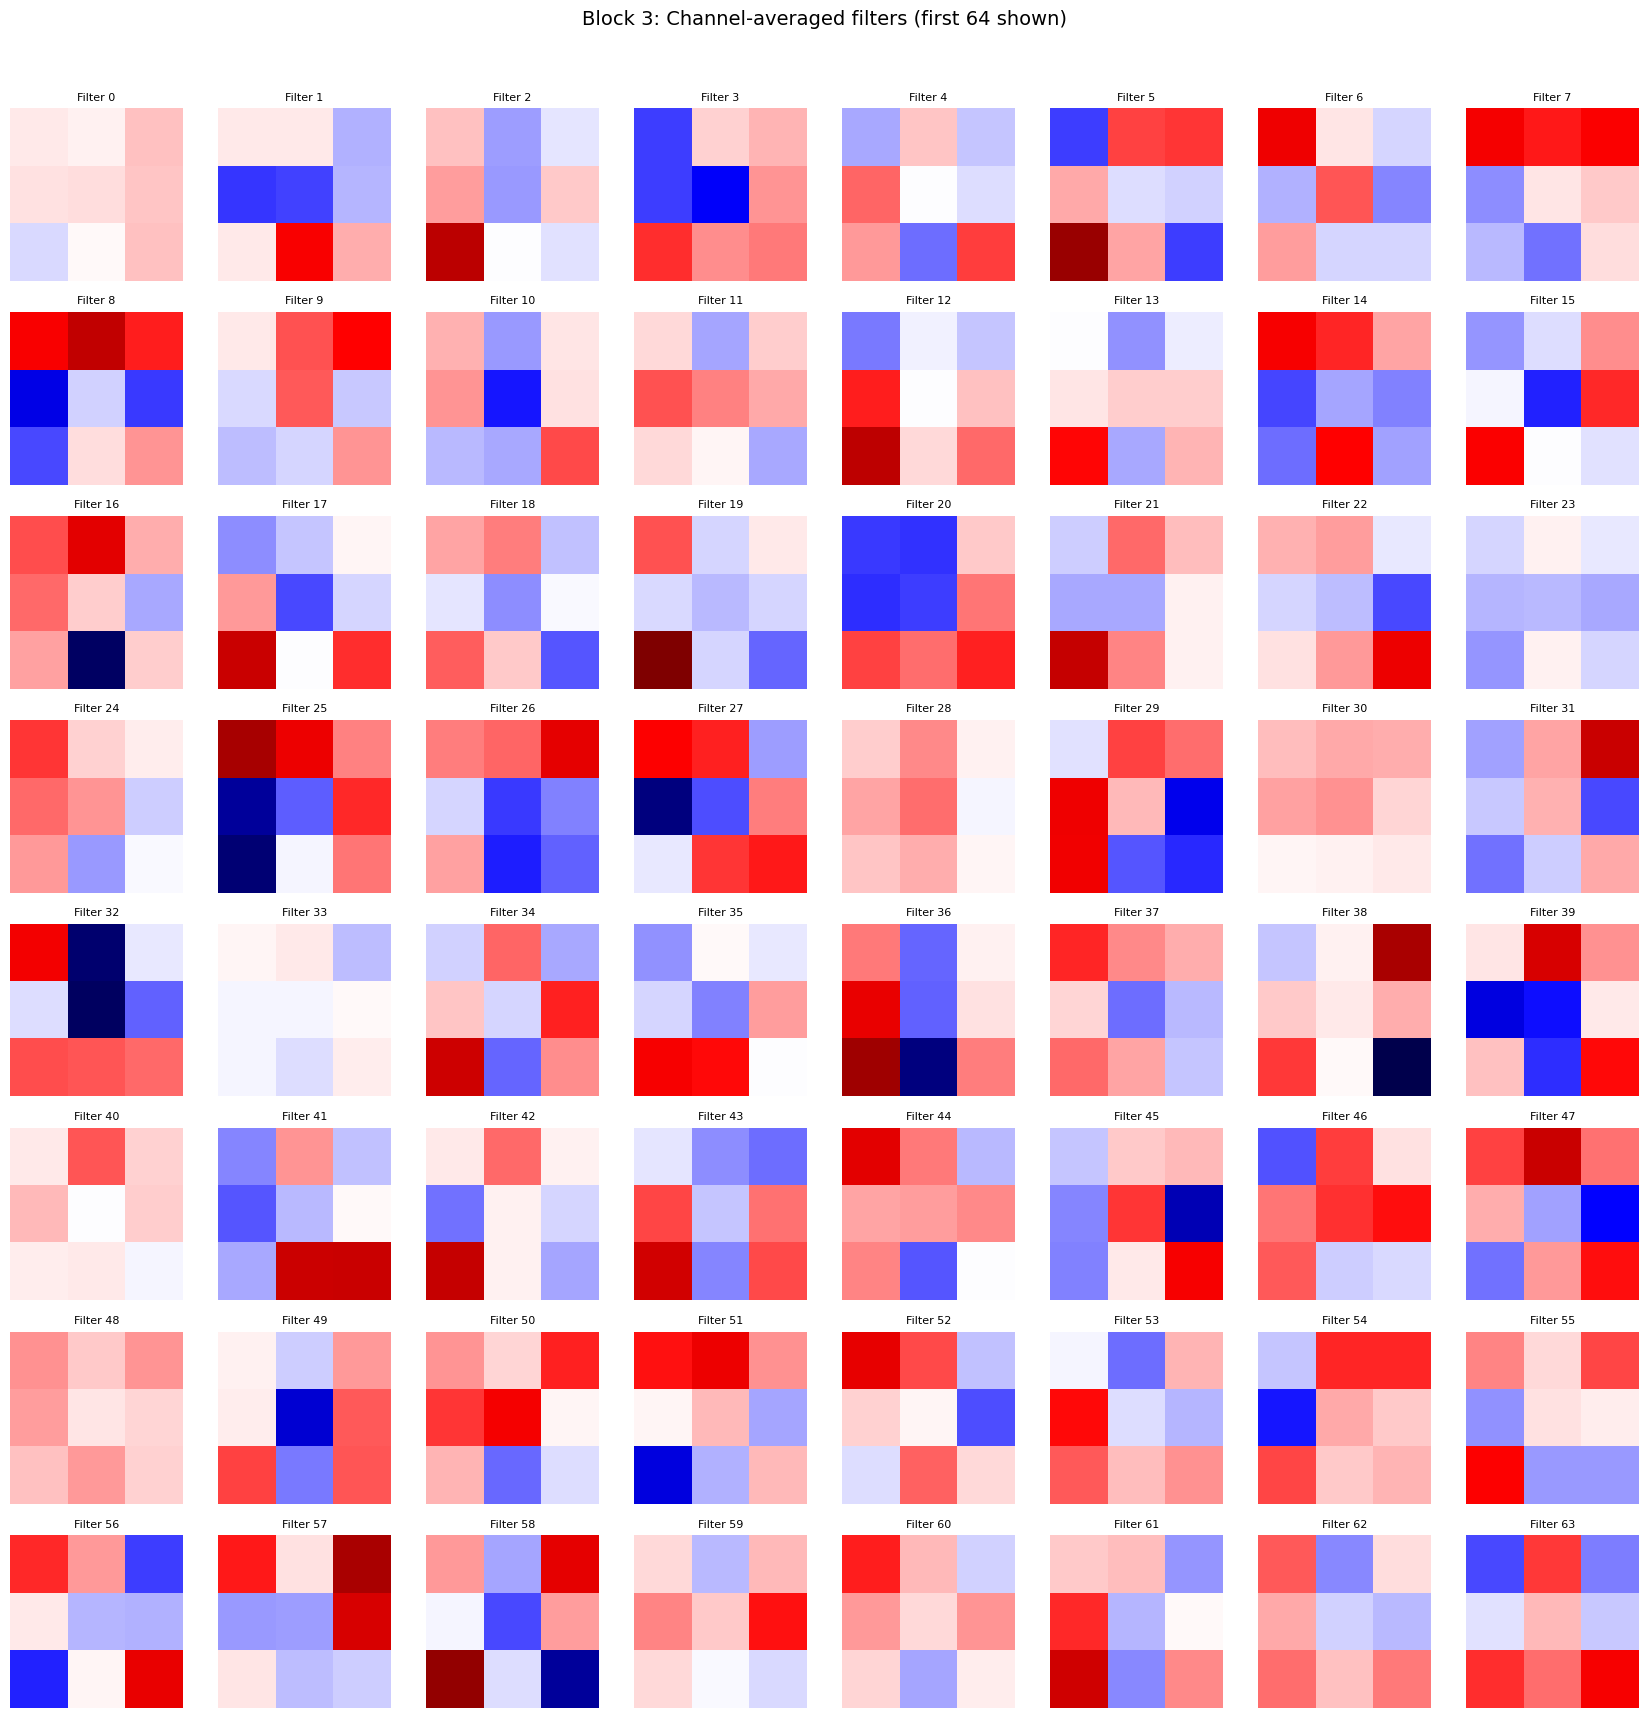

Each tile shows a single convolution filter. Blue/red indicates negative/positive weights.


In [ ]:

import math
import numpy as np

net.eval()
conv_layers = [layer for layer in net.features if isinstance(layer, nn.Conv2d)]

if len(conv_layers) == 0:
    raise RuntimeError("This notebook expects the CNN to contain convolutional layers.")


def plot_filter_grid(weight_maps, title):
    num_filters = weight_maps.shape[0]
    cols = min(8, num_filters)
    rows = int(math.ceil(num_filters / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.1, rows * 2.1))
    fig.suptitle(title, fontsize=14, y=1.02)
    axes = np.array(axes).reshape(rows, cols)

    vmin = weight_maps.min().item()
    vmax = weight_maps.max().item()

    for idx, ax in enumerate(axes.flat):
        if idx < num_filters:
            ax.imshow(weight_maps[idx], cmap='seismic', vmin=vmin, vmax=vmax)
            ax.set_title(f'Filter {idx}', fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# First block operates on grayscale pixels, so we can view filters directly
first_filters = conv_layers[0].weight.data.detach().cpu()
plot_filter_grid(first_filters[:, 0], 'Block 1: Learned edge/curve detectors')

# Deeper blocks have multi-channel inputs. We average across channels to inspect the pattern.
for block_idx, conv in enumerate(conv_layers[1:], start=2):
    weights = conv.weight.data.detach().cpu().mean(dim=1)
    plot_filter_grid(weights, f'Block {block_idx}: Channel-averaged filters (first {weights.shape[0]} shown)')

print('Each tile shows a single convolution filter. Blue/red indicates negative/positive weights.')



# 8. Visualize Activation Maps on a Test Item

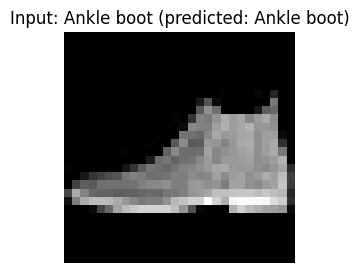

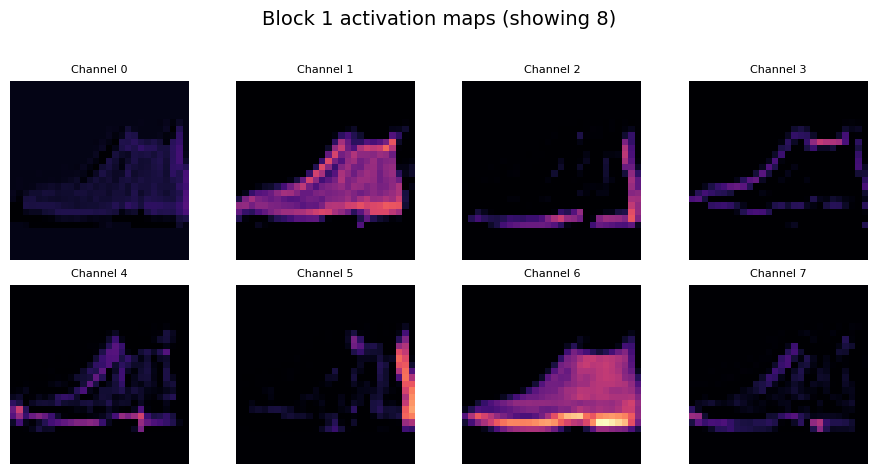

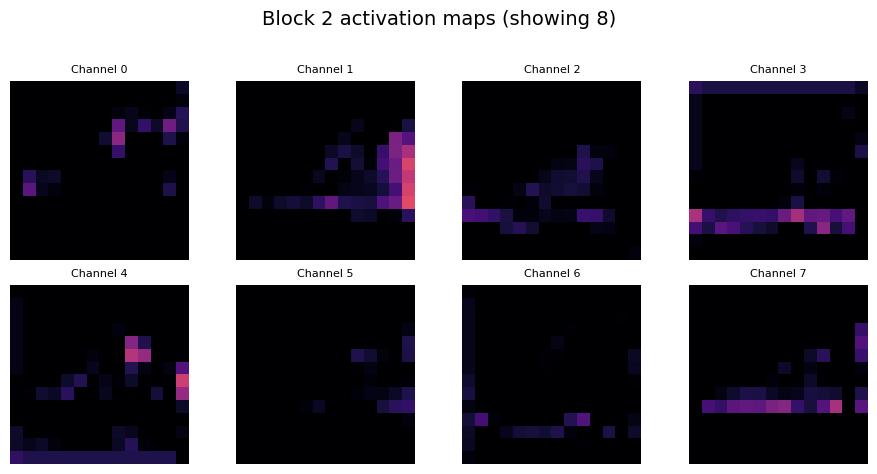

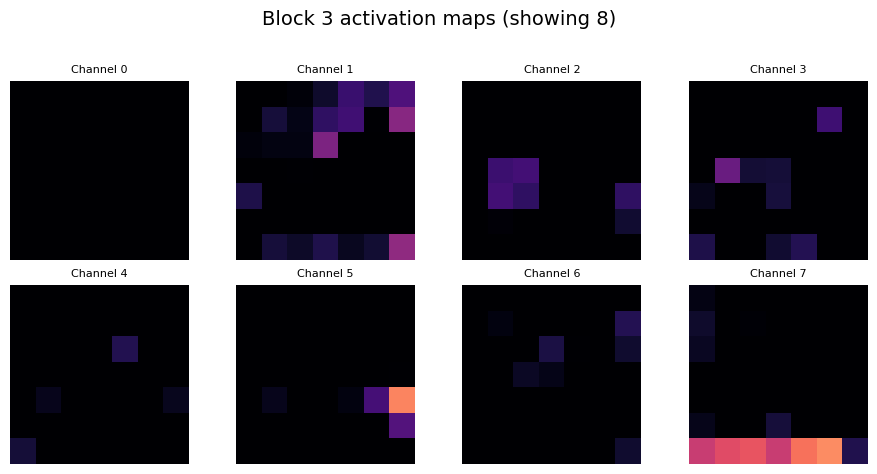

Bright regions show where the network is attending after each convolution block.


In [ ]:

net.eval()
device = next(net.parameters()).device

fashion_classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
                   'Sandal','Shirt','Sneaker','Bag','Ankle boot']

sample_images, sample_labels = next(iter(test_gen))
input_image = sample_images[0:1].to(device)  # shape [1,1,28,28]
true_label = sample_labels[0].item()

with torch.no_grad():
    prediction = torch.argmax(net(input_image), dim=1).item()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(sample_images[0].squeeze(), cmap='gray')
ax.set_title(f'Input: {fashion_classes[true_label]} (predicted: {fashion_classes[prediction]})')
ax.axis('off')
plt.show()

activations = []
current = input_image.clone()
block_idx = 0
for layer in net.features:
    current = layer(current)
    if isinstance(layer, torch.nn.ReLU):
        block_idx += 1
        activations.append((block_idx, current.detach().cpu()))

def plot_activation_maps(block_id, activation_tensor):
    """Plot a subset of activation maps for a given block."""
    num_maps = min(8, activation_tensor.shape[1])  
    cols = 4
    rows = int(math.ceil(num_maps / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.3, rows * 2.3))
    fig.suptitle(f'Block {block_id} activation maps (showing {num_maps})', fontsize=14, y=1.02)
    axes = np.array(axes).reshape(rows, cols)

    act_min = activation_tensor.min().item()
    act_max = activation_tensor.max().item()

    for idx, ax in enumerate(axes.flat):
        if idx < num_maps:
            ax.imshow(activation_tensor[0, idx], cmap='magma', vmin=act_min, vmax=act_max)
            ax.set_title(f'Channel {idx}', fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

for block_id, activation_tensor in activations:
    plot_activation_maps(block_id, activation_tensor)

print('Bright regions show where the network is attending after each convolution block.')


# 9. Visualize Sample Predictions

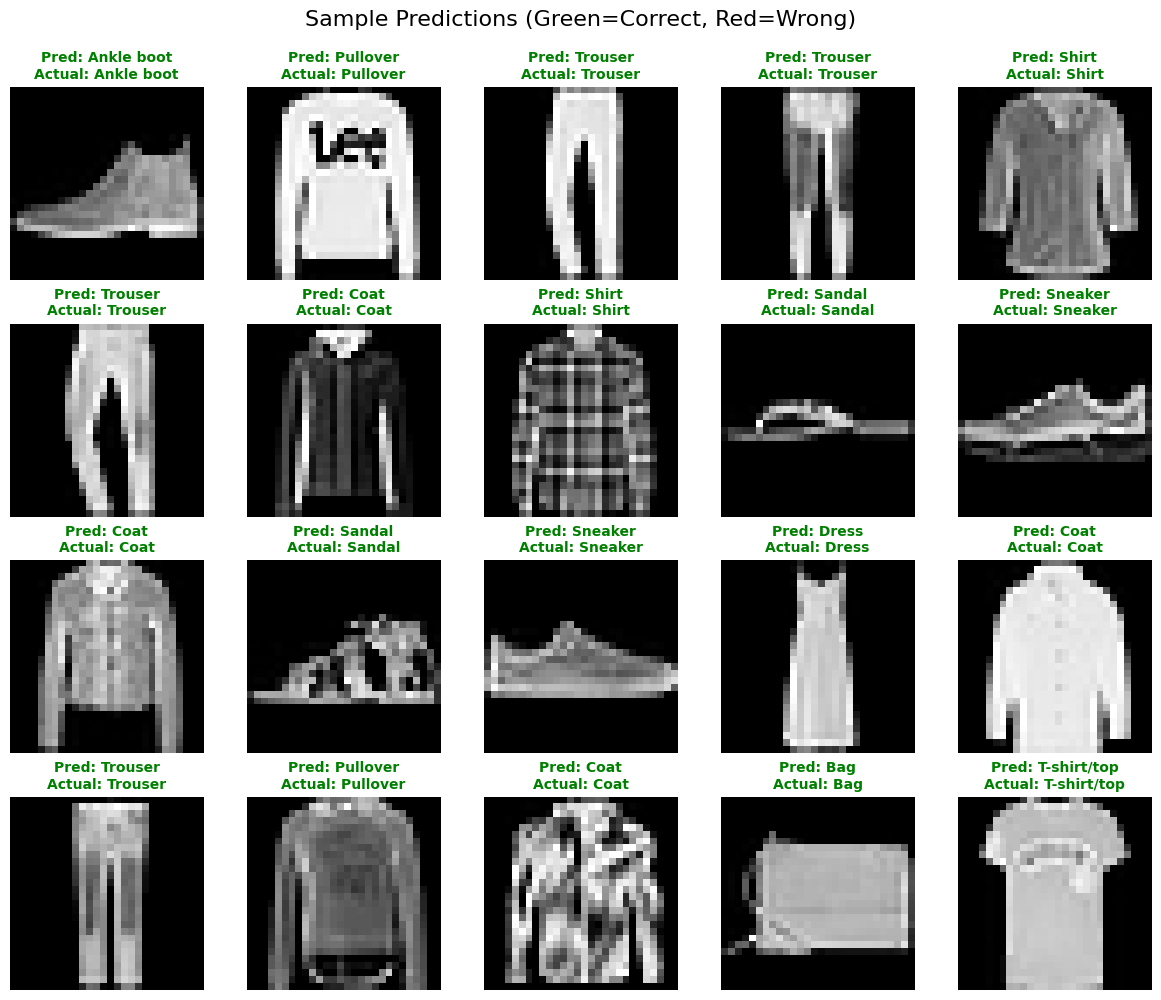


Batch Statistics:
Correct predictions: 117/128 (91.4%)


In [ ]:

import matplotlib.pyplot as plt
import torch



dataiter = iter(test_gen)
images, labels = next(dataiter)  # images shape: [batch, 1, 28, 28]

device = next(net.parameters()).device
images = images.to(device)
labels = labels.to(device)

net.eval()
with torch.no_grad():
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

images_np = images.cpu().numpy()
predicted_np = predicted.cpu().numpy()
labels_np = labels.cpu().numpy()

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=16, y=0.995)

for idx, ax in enumerate(axes.flat):
    if idx < len(images_np):
        ax.imshow(images_np[idx].squeeze(), cmap='gray')

        is_correct = predicted_np[idx] == labels_np[idx]
        color = 'green' if is_correct else 'red'

        title = f'Pred: {fashion_classes[predicted_np[idx]]}\nActual: {fashion_classes[labels_np[idx]]}'
        ax.set_title(title, fontsize=10, color=color, weight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()

num_correct = (predicted_np == labels_np).sum()
print(f'\nBatch Statistics:')
print(f'Correct predictions: {num_correct}/{len(labels_np)} ({100*num_correct/len(labels_np):.1f}%)')

# 10. Find and Display Misclassified Examples

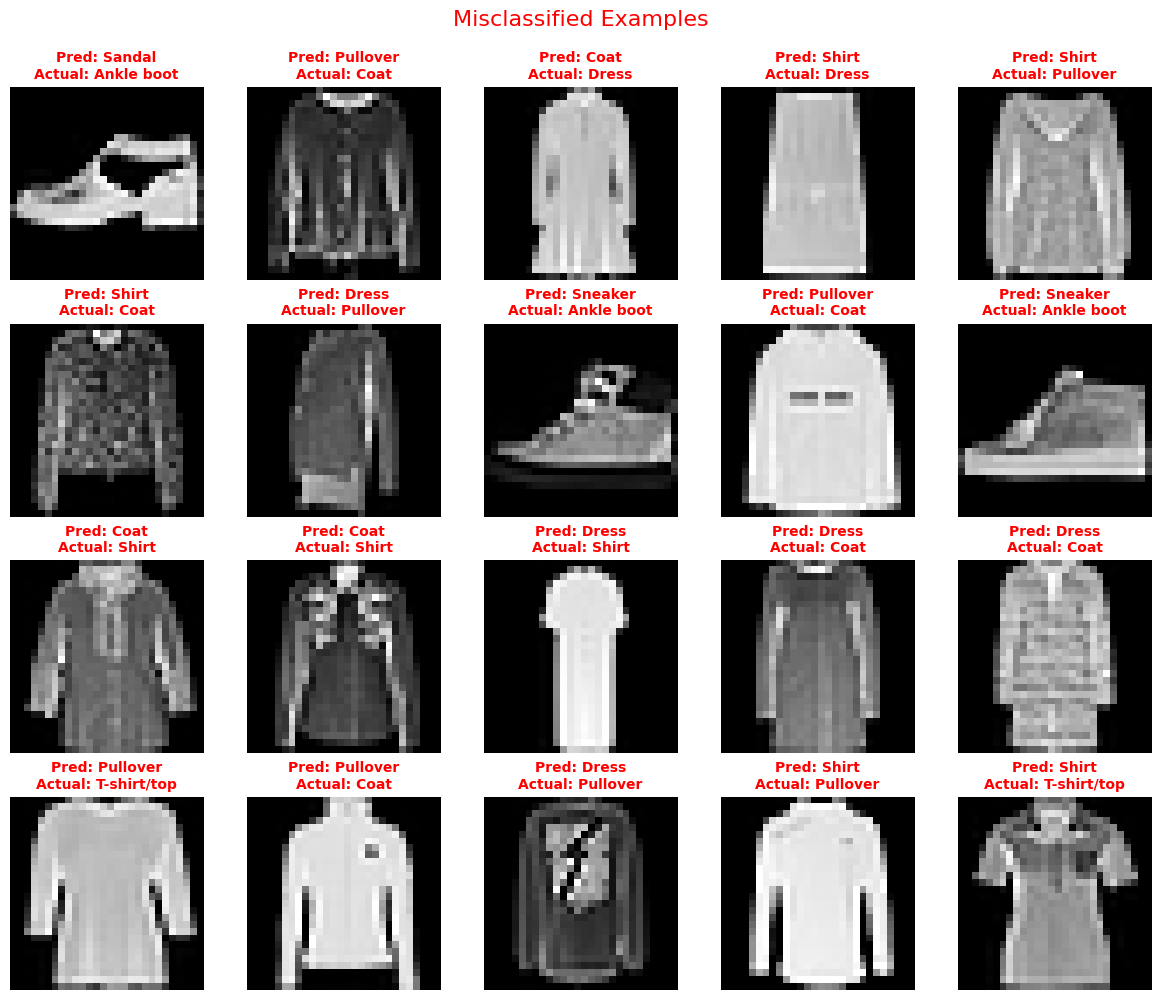


Showing 20 misclassified examples
These are cases where the model made mistakes.
Analyzing these can help identify patterns in model errors.


In [ ]:
#@title Find and Display Misclassified Examples (FashionMNIST)

import matplotlib.pyplot as plt
import torch

# Названия классов FashionMNIST
fashion_classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
                   'Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Сбор misclassified примеров
net.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in test_gen:
        images = images.to(next(net.parameters()).device)
        labels = labels.to(next(net.parameters()).device)

        # Прогон через сеть
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        # Индексы неверно классифицированных
        wrong_idx = (predicted != labels).nonzero(as_tuple=True)[0]

        for idx in wrong_idx:
            if len(misclassified_images) < 20:  # максимум 20 примеров
                misclassified_images.append(images[idx].cpu().numpy())
                misclassified_labels.append(labels[idx].item())
                misclassified_preds.append(predicted[idx].item())

        if len(misclassified_images) >= 20:
            break

# Визуализация misclassified примеров
if len(misclassified_images) > 0:
    num_examples = len(misclassified_images)
    rows = (num_examples + 4) // 5  # количество рядов
    fig, axes = plt.subplots(rows, 5, figsize=(12, 2.5*rows))
    fig.suptitle('Misclassified Examples', fontsize=16, color='red', y=0.995)

    # Если только один ряд
    if rows == 1:
        axes = axes.reshape(1, -1)

    for idx, ax in enumerate(axes.flat):
        if idx < num_examples:
            # Отображаем изображение
            ax.imshow(misclassified_images[idx].squeeze(), cmap='gray')

            # Заголовок с предсказанием и правильным классом
            title = f'Pred: {fashion_classes[misclassified_preds[idx]]}\nActual: {fashion_classes[misclassified_labels[idx]]}'
            ax.set_title(title, fontsize=10, color='red', weight='bold')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    print(f'\nShowing {num_examples} misclassified examples')
    print('These are cases where the model made mistakes.')
else:
    print('No misclassified examples found in the test set!')
